In [61]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn
import sklearn.metrics as metrics
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from datetime import date,datetime
import import_ipynb
import shutil
from data_loader import HDF5Dataset, BatchLoader, BatchLoaderTwoFiles


# If n_gesamt, n_split1, n_split2 do not match the definition in HDF5_Split_Hadron. Define manually here:
n_split1 = 10000
n_split2 = 10000
n_gesamt = n_split1 + n_split2
training_percentage = 80
validation_percentage = 10
test_percentage = 10

In [62]:
# Make sure we have a GPU allocated
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()
print(device) # The output should be 'cuda'

cuda


# Now we start with the Neural Network

In [72]:
# Defining the Models

class NeuralNet_fully_connected(nn.Module):
    def __init__(self):
        super(NeuralNet_fully_connected, self).__init__()
        
        self.fc1 = nn.Linear(48*25*25, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)                                #self.fc3 = nn.Linear(256, 2)
        #self.fc4 = nn.Linear(128, 1)
        
        
        
    def forward(self, x):
        
        leakyRelu_slope = 0.1
        
        x = x.view(-1,48*25*25) 
        x = x.to(device)
        x = self.fc1(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = self.fc2(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = self.fc3(x)
        #x = F.leaky_relu(x,leakyRelu_slope)
        #x = self.fc4(x)
        
        return x
    

class NeuralNet_convolutional(nn.Module):
    def __init__(self):
        super(NeuralNet_convolutional, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 32, 5, 1)
        self.conv2 = nn.Conv3d(32, 64, 3, 1)
        self.conv3 = nn.Conv3d(64, 64, 3, 1)
               
        self.fc1 = nn.Linear(2048, 512) # adjust input size like this x.shape[1]*x.shape[2]*x.shape[3]*x.shape[4]
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
        
        
    def forward(self, x):
        
        leakyRelu_slope = 0.1
    
        x = x.view(params_convolutional["batch_size"]*2,1,48,25,25)
        
        x = self.conv1(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = F.max_pool3d(x, 2)
        x = self.conv2(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = F.max_pool3d(x, 2)
        x = self.conv3(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        
        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]*x.shape[4])
        x = self.fc1(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = self.fc2(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = self.fc3(x)
        x = F.leaky_relu(x,leakyRelu_slope)
        x = self.fc4(x)
        
        return x

# Define Transformations

In [73]:
def threshold(x, threshmin, newval=0.0):
        x[x < threshmin] = newval
        return x

def tf_core25_thresh(x):
        if len(x.shape) == 4:
            return threshold(x[:, :, 13:38, 11:36], threshmin=0.0001, newval=0.0)
        else: 
            return threshold(x[:, 13:38, 11:36], threshmin=0.0001, newval=0.0)

# SWITCH BETWEEN MODELS - Fully Connected Network

In [74]:

# Loss function
criterion = nn.BCEWithLogitsLoss()  # when no sigmoid in last layer - sigmoid is integrated

# Create network object
model = NeuralNet_fully_connected().to(device)

# Create optimizer object - Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


# Loading a pretrained Fully Connected Network

In [75]:
#model.load_state_dict(torch.load("/beegfs/desy/user/schreibj/Hadron_classifier/Models/Hadron_classifier_fully_connected_2022-11-14.pt"))
model.eval()
#model.to(device)

NeuralNet_fully_connected(
  (fc1): Linear(in_features=30000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

# Define Parameters - Fully connected NN

In [76]:
params_fully_connected = {
        
        "model" : "fully_connected",

        # IO
        "input_path"  : '/beegfs/desy/user/diefenbs/shower_data/pion_uniform_510k_PunchThroughCut70.hdf5',
        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_orig.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_trafo_1,0Sigma.hdf5',
        "file_path3" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_orig_validation.hdf5',
        "file_path4" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_trafo_1,0Sigma_validation.hdf5',
        "file_path5" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_orig_test.hdf5',
        "file_path6" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_trafo_1,0Sigma_test.hdf5',
        "output_path" : '/beegfs/desy/user/schreibj/Hadron_classifier/results/',

        "batch_size" : 256, #256 baseline
        "batch_size2" : 256,
        "epochs" : 10,
        'no_cuda': False,
        "train_size" : int(n_split1*training_percentage*0.01) , 
        "train_size2" : int(n_split2*training_percentage*0.01) , 
        "validation_size" : int(n_split1*validation_percentage*0.01) , 
        "validation_size2" : int(n_split2*validation_percentage*0.01) , 
        "test_size" : int(n_split1*test_percentage*0.01) ,
        "test_size2" :  int(n_split2*test_percentage*0.01) , 
        'shuffle': True,
        "ENR_Cut_Cutoff" : 0.1,
        'lr_fully_connected' : 0.001,
        'opt_fully_connecte' : 'Adam',
        'SafeAfterEpochOnly' : True,
        "save_iter_interval" : 50,
    }

In [77]:
print(f'train_size: {params_fully_connected["train_size"]}')
print(f'train_size2: {params_fully_connected["train_size2"]}')
print(f'validation_size: {params_fully_connected["validation_size"]}')
print(f'validation_size2: {params_fully_connected["validation_size2"]}')
print(f'test_size: {params_fully_connected["test_size"]}')
print(f'test_size2: {params_fully_connected["test_size2"]}')

train_size: 8000
train_size2: 8000
validation_size: 1000
validation_size2: 1000
test_size: 1000
test_size2: 1000


In [78]:
start = datetime.now()

train_loader = BatchLoaderTwoFiles(file_path1 = params_fully_connected["file_path1"],
                                   file_path2 = params_fully_connected["file_path2"],
                                   train_size = params_fully_connected["train_size"], 
                                   train_size2 = params_fully_connected["train_size2"], 
                                   batch_size = params_fully_connected["batch_size"], 
                                   batch_size2 = params_fully_connected["batch_size2"], 
                                   shuffle=True, 
                                   transform=tf_core25_thresh)

validation_loader = BatchLoaderTwoFiles(file_path1 = params_fully_connected["file_path3"],
                                   file_path2 = params_fully_connected["file_path4"],
                                   train_size = params_fully_connected["validation_size"], 
                                   train_size2 = params_fully_connected["validation_size2"], 
                                   batch_size = params_fully_connected["batch_size"], 
                                   batch_size2 = params_fully_connected["batch_size2"], 
                                   shuffle=True, 
                                   transform=tf_core25_thresh)

test_loader = BatchLoaderTwoFiles(file_path1 = params_fully_connected["file_path5"],
                                   file_path2 = params_fully_connected["file_path6"],
                                   train_size = params_fully_connected["test_size"], 
                                   train_size2 = params_fully_connected["test_size2"], 
                                   batch_size = params_fully_connected["batch_size"], 
                                   batch_size2 = params_fully_connected["batch_size2"], 
                                   shuffle=True, 
                                   transform=tf_core25_thresh)

for batch_idx, (data, energy, label) in enumerate(train_loader):
    print('train_loader',batch_idx, data.shape, energy.shape, label.shape)
    
for batch_idx, (data, energy, label) in enumerate(validation_loader):
    print('validation_loader',batch_idx, data.shape, energy.shape, label.shape)
    
for batch_idx, (data, energy, label) in enumerate(test_loader):
    print('test_loader',batch_idx, data.shape, energy.shape, label.shape)
    
    
end = datetime.now()
print(f'total time: {end - start}')

train_loader 0 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 1 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 2 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 3 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 4 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 5 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 6 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 7 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 8 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 9 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 10 torch.Size([512, 48, 25, 25]) torch.Size([512, 1]) torch.Size([512, 1])
train_loader 11 torch.Size([512, 48, 25, 2

# Check whether actually loaded number of batches fits the expected amount of batches

In [79]:
print(int(params_fully_connected["train_size"]/params_fully_connected["batch_size"]))
print(int(params_fully_connected["validation_size"]/params_fully_connected["batch_size"]))
print(int(params_fully_connected["test_size"]/params_fully_connected["batch_size"]))

31
3
3


# Train fully connected network

In [80]:
start = datetime.now()


# Keep track of the accuracies
train_accs_fully_connected = np.array([])
validation_accs_fully_connected = np.array([])
losses_fully_connected_batchwise = np.array([])


# Initializing a counter for setting a limit to the training procedure
batch_counter = 0
epoch_counter = 0

n_batches_train = int(params_fully_connected["train_size"]/params_fully_connected["batch_size"])
n_batches_validation = int(params_fully_connected["validation_size"]/params_fully_connected["batch_size"]) #7#int(params_fully_connected["validation_size"]/params_fully_connected["batch_size"]) #Bestimmung von n_batches_validation funktioniert derzeit nur manuell... Automatisieren!
n_batches_test = int(params_fully_connected["test_size"]/params_fully_connected["batch_size"]) #7#int(params_fully_connected["test_size"]/params_fully_connected["batch_size"])


# Training/Evaluation Loop

for epoch_idx in range(params_fully_connected["epochs"]):

    # Calculate predictions
    train_acc_fully_connected = 0
    validation_acc_fully_connected = 0
    loss_fully_connected_batchwise = 0
    
    model.train() # Switch Model to training_mode
    
    
    #LOADING THE TRAININGDATA
    for batch_idx, (data, energy, label) in enumerate(train_loader):
    
        #TRAINING THE MODEL: 
        
        
        # Reset gradient
        optimizer.zero_grad()
        
        net_out = model(data.to(device))
        
        
        # Calculate the loss function
        label = torch.tensor(label,dtype=torch.float).to(device)
        loss = criterion(net_out,label)
        
        
        # Evaluating the training loss batchwise for the first epoch - Troubleshooting
        if epoch_counter < 3:
            loss_fully_connected_batchwise = loss
            losses_fully_connected_batchwise = np.append(losses_fully_connected_batchwise,loss_fully_connected_batchwise.item())
        
             
        # Calculate the gradients
        loss.backward()
        
        
        # Update the weights
        optimizer.step()
        
        
        # Keeping track of number of batches in one epoch:
        batch_counter += 1
    
        print(f"Fully Connected Network Epoch: batch number: {batch_counter},epoch number: {epoch_counter}")
    
    
    # end of loop over batches
    
    epoch_counter += 1
    print(f'Number of epochs trained: {epoch_counter}')
    

    # EVALUATING THE MODEL after each epoch: 
    model.eval() # Switch Model to evaluation_mode
    
    
    # 1. Evaluation on Trainingdata:
    for batch_idx, (data, energy, label) in enumerate(train_loader):
        print(f'Evaluation on Trainingdata batch_idx,{batch_idx}')
        
        with torch.no_grad(): 
            label_pred_train = torch.round(torch.sigmoid(net_out.detach()))
    
        train_acc_fully_connected += sum(label.to(device) == label_pred_train) / label.shape[0]
    
    train_acc_fully_connected /= n_batches_train
    
    # print some information
    print("Fully Connected Network Epoch:",epoch_counter, "Train Accuracy:", train_acc_fully_connected.item())
              
    # and store the accuracy for later use
    train_accs_fully_connected = np.append(train_accs_fully_connected,train_acc_fully_connected.item())
                      
              
    # 2. Evaluation on Evaluationdata:   
    for batch_idx, (data, energy, label) in enumerate(validation_loader):
        print(f'Evaluation on Validationdata batch_idx,{batch_idx}')
        
        net_out_validation = model(data.to(device))
        
        with torch.no_grad(): 
            label_pred_validation = torch.round(torch.sigmoid(net_out_validation.detach()))
              
        validation_acc_fully_connected += sum(label.to(device) == label_pred_validation) / label.shape[0]
              
    validation_acc_fully_connected /= n_batches_validation
    
    # print some information
    print("Fully Connected Network Epoch:",epoch_counter, "Validation Accuracy:", validation_acc_fully_connected.item())
              
    # and store the accuracy for later use
    validation_accs_fully_connected = np.append(validation_accs_fully_connected,validation_acc_fully_connected.item())
    

    # end of loop over epochs     
          
# saving the model
torch.save(model.state_dict(), f"/beegfs/desy/user/schreibj/Hadron_classifier/Models/Hadron_classifier_fully_connected_{str(datetime.now())}.pt")

end = datetime.now()
print(f'total time: {end - start}')

Fully Connected Network Epoch: batch number: 1,epoch number: 0
Fully Connected Network Epoch: batch number: 2,epoch number: 0
Fully Connected Network Epoch: batch number: 3,epoch number: 0
Fully Connected Network Epoch: batch number: 4,epoch number: 0
Fully Connected Network Epoch: batch number: 5,epoch number: 0
Fully Connected Network Epoch: batch number: 6,epoch number: 0
Fully Connected Network Epoch: batch number: 7,epoch number: 0
Fully Connected Network Epoch: batch number: 8,epoch number: 0
Fully Connected Network Epoch: batch number: 9,epoch number: 0
Fully Connected Network Epoch: batch number: 10,epoch number: 0
Fully Connected Network Epoch: batch number: 11,epoch number: 0
Fully Connected Network Epoch: batch number: 12,epoch number: 0
Fully Connected Network Epoch: batch number: 13,epoch number: 0
Fully Connected Network Epoch: batch number: 14,epoch number: 0
Fully Connected Network Epoch: batch number: 15,epoch number: 0
Fully Connected Network Epoch: batch number: 16,e

# Plotting the Loss - after each batch (for the first epochs) 

losses_fully_connected_batchwise.shape: 10


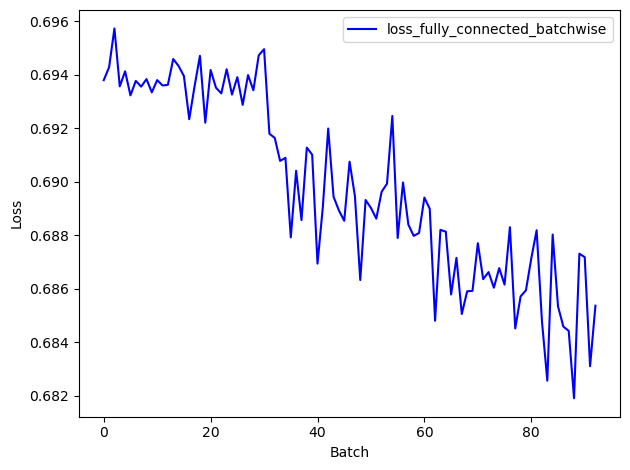

In [81]:
print(f'losses_fully_connected_batchwise.shape: {len(train_accs_fully_connected)}')
plt.axis('on')
plt.plot(losses_fully_connected_batchwise,label="loss_fully_connected_batchwise",color='blue')
plt.legend()
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig(f'/beegfs/desy/user/schreibj/Hadron_classifier/Plots/Loss_plot_Hadron_showers_fully_connected_batchwise_{str(datetime.now())}.pdf')

# Plotting the accuracy - after each epoch

train_accs_fully_connected.shape: 10
validation_accs_fully_connected.shape: 10
Error occurred while copying file.


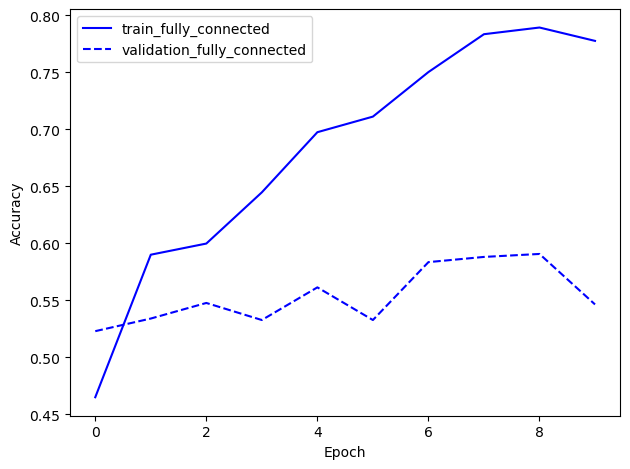

In [82]:
print(f'train_accs_fully_connected.shape: {len(train_accs_fully_connected)}')
print(f'validation_accs_fully_connected.shape: {len(validation_accs_fully_connected)}')
plt.axis('on')
plt.plot(train_accs_fully_connected,label="train_fully_connected",color='blue')
plt.plot(validation_accs_fully_connected,label="validation_fully_connected",color='blue',linestyle='dashed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(f'/beegfs/desy/user/schreibj/Hadron_classifier/Plots/Accuracy_plot_Hadron_showers_{str(datetime.now())}.pdf')


#Saving the script

# Source path
source = "/home/schreibj/Hadron_classifier/Classifier_Hadron_showers.ipynb"
 
# Destination path
destination = f"/beegfs/desy/user/schreibj/Hadron_classifier/Script_saves/Script_saves_{str(datetime.now())}.txt"
 
# Copy the content of
# source to destination
 
try:
    shutil.copy(source, destination)
    print("File copied successfully.")
 
# If source and destination are same
except shutil.SameFileError:
    print("Source and destination represents the same file.")
 
# If there is any permission issue
except PermissionError:
    print("Permission denied.")
 
# For other errors
except:
    print("Error occurred while copying file.")

In [83]:
print(train_accs_fully_connected)
print(validation_accs_fully_connected)

[0.46484375 0.58984375 0.59960938 0.64453125 0.69726562 0.7109375
 0.75       0.78320312 0.7890625  0.77734375]
[0.5227865  0.53385419 0.54752606 0.53255212 0.56119794 0.53255212
 0.58333337 0.58789062 0.59049481 0.546224  ]


# SWITCH BETWEEN MODELS - Convolutional Network

In [84]:
# Loss function
criterion = nn.BCEWithLogitsLoss() 

# Create network object
model = NeuralNet_convolutional().to(device)

# Create optimizer object - Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


# Loading a pretrained Convolutional Network

In [85]:
#model.load_state_dict(torch.load("/beegfs/desy/user/schreibj/Hadron_classifier/Models/Hadron_classifier_convolutional_2022-11-14.pt"))
#model.eval()
#model.to(device)

# Define Parameters - Convolutional Network

In [86]:
params_convolutional = {
        
        "model" : "convolutional",
        
        # IO
        "input_path"  : '/beegfs/desy/user/diefenbs/shower_data/pion_uniform_510k_PunchThroughCut70.hdf5',
        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_orig.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_trafo_1,0Sigma.hdf5',
        "file_path3" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_orig_validation.hdf5',
        "file_path4" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_trafo_1,0Sigma_validation.hdf5',
        "file_path5" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_orig_test.hdf5',
        "file_path6" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_10k_trafo_1,0Sigma_test.hdf5',
        "output_path" : '/beegfs/desy/user/schreibj/Hadron_classifier/results/',

        "batch_size" : 256, 
        "batch_size2" : 256,
        "epochs" : 10,
        'no_cuda': False,
        "train_size" : int(n_split1*training_percentage*0.01) , # n_split1*train_percentage*0.01 #spaeter 100000 #bug... wenn Trainsize = groesse des gesamten zu ladenden Datensets fehlt immer der letzte batch... #Das ist kein Bug das muss so... aus performance Gründen
        "train_size2" : int(n_split2*training_percentage*0.01) , # n_split2*train_percentage*0.01 # 7500
        "validation_size" : int(n_split1*validation_percentage*0.01) , # n_split1*validation_percentage*0.01 #1500
        "validation_size2" : int(n_split2*validation_percentage*0.01) , # n_split2*validation_percentage*0.01
        "test_size" : int(n_split1*test_percentage*0.01) , # n_split1*test_percentage*0.01
        "test_size2" :  int(n_split2*test_percentage*0.01) , # n_split2*test_percentage*0.01
        'shuffle': True,
        "ENR_Cut_Cutoff" : 0.1,
        'lr_convolutional' : 0.00001,
        'opt_fully_connecte' : 'Adam',
        'SafeAfterEpochOnly' : True,
        "save_iter_interval" : 50,
    }

# Training the convolutional Network

In [87]:
start = datetime.now()


# Keep track of the accuracies
train_accs_convolutional = np.array([])
validation_accs_convolutional = np.array([])
losses_convolutional_batchwise = np.array([])


# Initializing a counter for keeping track of the training procedure
batch_counter = 0
epoch_counter = 0

n_batches_train = int(params_convolutional["train_size"]/params_convolutional["batch_size"])
n_batches_validation = int(params_convolutional["validation_size"]/params_convolutional["batch_size"]) #7#int(params_convolutional["validation_size"]/params_convolutional["batch_size"]) #Bestimmung von n_batches_validation funktioniert derzeit nur manuell... Automatisieren!
n_batches_test = int(params_convolutional["test_size"]/params_convolutional["batch_size"]) #7#int(params_convolutional["test_size"]/params_convolutional["batch_size"])


# Training/Evaluation Loop

for epoch_idx in range(params_convolutional["epochs"]):

    # Calculate predictions
    train_acc_convolutional = 0
    validation_acc_convolutional = 0
    loss_convolutional_batchwise = 0
    
    model.train() # Switch Model to training_mode
    
    
    #LOADING THE TRAININGDATA
    for batch_idx, (data, energy, label) in enumerate(train_loader):
        
        #TRAINING THE MODEL: 
        
        
        # Reset gradient
        optimizer.zero_grad()
        
        
        # Apply the network 
        net_out = model(data.to(device))

        
        # Calculate the loss function
        label = torch.tensor(label,dtype=torch.float).to(device)
        loss = criterion(net_out,label)
        
        
        # Evaluating the training loss batchwise 
        if epoch_counter < 3:
            loss_convolutional_batchwise = loss
            losses_convolutional_batchwise = np.append(losses_convolutional_batchwise,loss_convolutional_batchwise.item())
        
        
        # Calculate the gradients
        loss.backward()
        
        
        # Update the weights
        optimizer.step()
        
        
        # Keeping track of number of batches in one epoch:
        batch_counter += 1
    
        print(f"Convolutional Network Epoch: batch number: {batch_counter},epoch number: {epoch_counter}")
    
    
    # end of loop over batches
       
    epoch_counter += 1
    print(f'Number of epochs trained: {epoch_counter}')
              
    
    # EVALUATING THE MODEL after each epoch: 
    model.eval()
    
    
    # 1. Evaluation on Trainingdata:
    for batch_idx, (data, energy, label) in enumerate(train_loader):
        print(f'Evaluation on Trainingdata batch_idx,{batch_idx}')
        with torch.no_grad(): 
            label_pred_train = torch.round(torch.sigmoid(net_out.detach()))
              
        # Calculate accuracy
        train_acc_convolutional += sum(label.to(device) == label_pred_train) / label.shape[0]
    
    train_acc_convolutional /= n_batches_train
    
    # print some information
    print("Convolutional Network Epoch:",epoch_counter, "Train Accuracy:", train_acc_convolutional)
              
    # and store the accuracy for later use
    train_accs_convolutional = np.append(train_accs_convolutional,train_acc_convolutional.item())
                   
              
    # 2. Evaluation on Evaluationdata:    
    for batch_idx, (data, energy, label) in enumerate(validation_loader):
        print(f'Evaluation on Validationdata batch_idx,{batch_idx}')
        
        net_out_validation = model(data.to(device))
        
        with torch.no_grad(): 
            label_pred_validation = nn.Softmax(dim=1)(model(torch.tensor(data,dtype=torch.float).to(device))).detach().cpu().numpy()
        
         
        # Calculate accuracy
        label_pred_validation = torch.round(torch.sigmoid(net_out_validation.detach()))
        validation_acc_convolutional += sum(label.to(device) == label_pred_validation) / label.shape[0]
    
    validation_acc_convolutional /= n_batches_validation
    
    # print some information
    print("Convolutional Network Epoch:",epoch_counter, "Validation Accuracy:", validation_acc_convolutional)
              
    # and store the accuracy for later use
    validation_accs_convolutional = np.append(validation_accs_convolutional,validation_acc_convolutional.item())
    
    
    # end of loop over epochs     
          
# saving the model /home/schreibj/Hadron_classifier/Hadron_classifier_models/
torch.save(model.state_dict(), f"/beegfs/desy/user/schreibj/Hadron_classifier/Models/Hadron_classifier_convolutional_{str(datetime.now())}.pt")

end = datetime.now()
print(f'total time: {end - start}')

Convolutional Network Epoch: batch number: 1,epoch number: 0
Convolutional Network Epoch: batch number: 2,epoch number: 0
Convolutional Network Epoch: batch number: 3,epoch number: 0
Convolutional Network Epoch: batch number: 4,epoch number: 0
Convolutional Network Epoch: batch number: 5,epoch number: 0
Convolutional Network Epoch: batch number: 6,epoch number: 0
Convolutional Network Epoch: batch number: 7,epoch number: 0
Convolutional Network Epoch: batch number: 8,epoch number: 0
Convolutional Network Epoch: batch number: 9,epoch number: 0
Convolutional Network Epoch: batch number: 10,epoch number: 0
Convolutional Network Epoch: batch number: 11,epoch number: 0
Convolutional Network Epoch: batch number: 12,epoch number: 0
Convolutional Network Epoch: batch number: 13,epoch number: 0
Convolutional Network Epoch: batch number: 14,epoch number: 0
Convolutional Network Epoch: batch number: 15,epoch number: 0
Convolutional Network Epoch: batch number: 16,epoch number: 0
Convolutional Net

# Plotting the Loss - after each batch (for the first epochs) 

losses_convolutional_batchwise.shape: 93


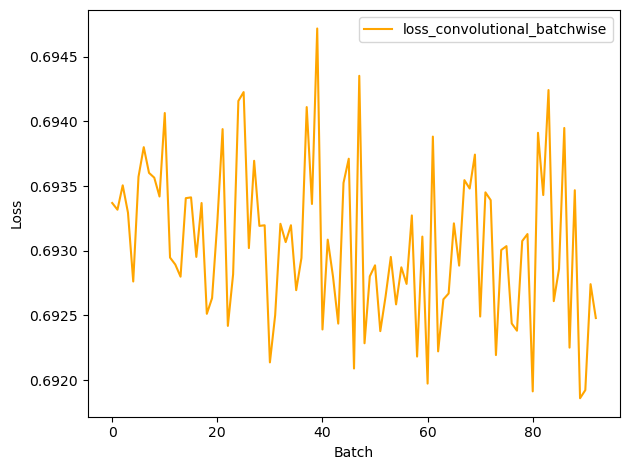

In [88]:
print(f'losses_convolutional_batchwise.shape: {len(losses_convolutional_batchwise)}')
plt.axis('on')
plt.plot(losses_convolutional_batchwise,label="loss_convolutional_batchwise",color='orange')
plt.legend()
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig(f'/beegfs/desy/user/schreibj/Hadron_classifier/Plots/Loss_plot_Hadron_showers_convolutional_batchwise_{str(datetime.now())}.pdf')

# Plotting the accuracy - after each epoch

train_accs_convolutional.shape: 10
validation_accs_convolutional.shape: 10
Error occurred while copying file.


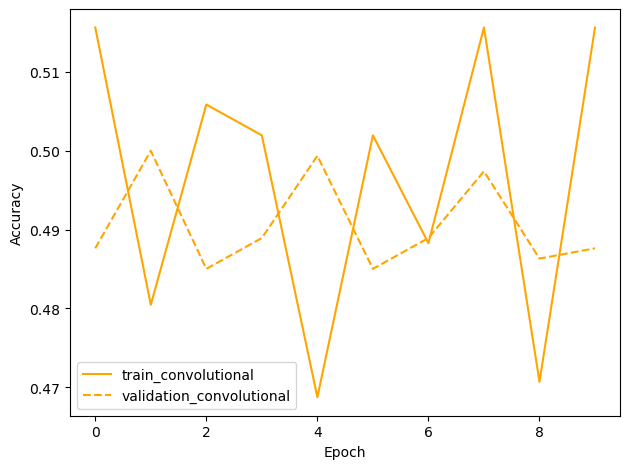

In [89]:
print(f'train_accs_convolutional.shape: {len(train_accs_convolutional)}')
print(f'validation_accs_convolutional.shape: {len(validation_accs_convolutional)}')
plt.axis('on')
plt.plot(train_accs_convolutional,label="train_convolutional",color='orange')
plt.plot(validation_accs_convolutional,label="validation_convolutional",color='orange',ls='dashed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(f'/beegfs/desy/user/schreibj/Hadron_classifier/Plots/Accuracy_plot_Hadron_showers_convolutional_{str(datetime.now())}.pdf')


#Saving the script

# Source path
source = "/home/schreibj/Hadron_classifier/Classifier_Hadron_showers.ipynb"
 
# Destination path
destination = f"/beegfs/desy/user/schreibj/Hadron_classifier/Script_saves/Script_saves_{str(datetime.now())}.txt"
 
# Copy the content of
# source to destination
 
try:
    shutil.copy(source, destination)
    print("File copied successfully.")
 
# If source and destination are same
except shutil.SameFileError:
    print("Source and destination represents the same file.")
 
# If there is any permission issue
except PermissionError:
    print("Permission denied.")
 
# For other errors
except:
    print("Error occurred while copying file.")

In [90]:
print(train_accs_convolutional)
print(validation_accs_convolutional)
print(losses_convolutional_batchwise)

[0.515625   0.48046875 0.50585938 0.50195312 0.46875    0.50195312
 0.48828125 0.515625   0.47070312 0.515625  ]
[0.48763022 0.5        0.48502606 0.48893231 0.49934897 0.48502606
 0.48893231 0.49739584 0.48632812 0.48763022]
[0.69336915 0.69331717 0.6935057  0.69329393 0.69276226 0.69357121
 0.69380069 0.69360203 0.69356477 0.69341934 0.6940645  0.69294727
 0.69289351 0.69279945 0.6934064  0.69341248 0.69295233 0.69336885
 0.69251239 0.6926344  0.69322348 0.69394016 0.69241911 0.69281816
 0.69415778 0.69422632 0.69302058 0.69369519 0.69319189 0.69319683
 0.692137   0.69250208 0.69320822 0.69306678 0.69319737 0.6926952
 0.69294453 0.69411039 0.69336146 0.69471788 0.6923914  0.69308579
 0.69280159 0.6924367  0.69352424 0.69371128 0.69208974 0.69435197
 0.69228488 0.69280195 0.69288743 0.69237852 0.69264579 0.69295216
 0.69258553 0.69287199 0.69274348 0.69327295 0.69218206 0.69310927
 0.69197309 0.69388229 0.69222212 0.69262415 0.69266975 0.69321167
 0.69288504 0.69354564 0.69348073 0.69

# Plotting the accuracy of all models together

train_accs_convolutional.shape: 10
validation_accs_convolutional.shape: 10
train_accs_fully_connected.shape: 10
validation_accs_fully_connected.shape: 10


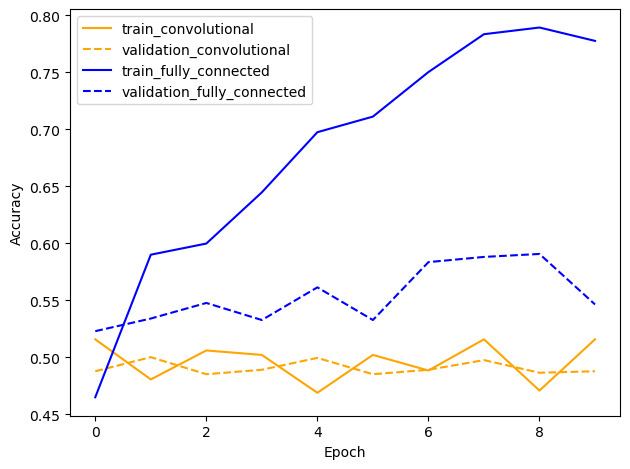

In [91]:
print(f'train_accs_convolutional.shape: {len(train_accs_convolutional)}')
print(f'validation_accs_convolutional.shape: {len(validation_accs_convolutional)}')
print(f'train_accs_fully_connected.shape: {len(train_accs_fully_connected)}')
print(f'validation_accs_fully_connected.shape: {len(validation_accs_fully_connected)}')
plt.axis('on')
plt.plot(train_accs_convolutional,label="train_convolutional",color='orange')
plt.plot(validation_accs_convolutional,label="validation_convolutional",color='orange',ls='dashed')
plt.plot(train_accs_fully_connected,label="train_fully_connected",color='blue')
plt.plot(validation_accs_fully_connected,label="validation_fully_connected",color='blue',linestyle='dashed')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(f'/beegfs/desy/user/schreibj/Hadron_classifier/Plots/Accuracy_plot_Hadron_showers_all_models_{str(datetime.now())}.pdf')

In [92]:
print(train_accs_fully_connected)
print(validation_accs_fully_connected)
print(losses_fully_connected_batchwise)
print(train_accs_convolutional)
print(validation_accs_convolutional)
print(losses_convolutional_batchwise)

[0.46484375 0.58984375 0.59960938 0.64453125 0.69726562 0.7109375
 0.75       0.78320312 0.7890625  0.77734375]
[0.5227865  0.53385419 0.54752606 0.53255212 0.56119794 0.53255212
 0.58333337 0.58789062 0.59049481 0.546224  ]
[0.69379783 0.69428098 0.69573081 0.69356668 0.69412905 0.69322991
 0.69377172 0.6935569  0.69383854 0.69334316 0.69380224 0.69359869
 0.69362473 0.69458848 0.69433057 0.69395304 0.6923393  0.69357646
 0.69470775 0.69220877 0.69417953 0.69351578 0.69330454 0.69420683
 0.69326067 0.69390988 0.69287354 0.69398952 0.69342095 0.69472694
 0.69495714 0.69179547 0.69163847 0.69077957 0.69089413 0.68791962
 0.69041008 0.68856657 0.69127756 0.69101179 0.68693966 0.68906319
 0.69199151 0.68944097 0.68892908 0.688541   0.69075012 0.6894592
 0.68632436 0.68931794 0.68901944 0.6886217  0.68962705 0.68992507
 0.6924603  0.68789756 0.68997395 0.68839824 0.68797666 0.68808508
 0.68940872 0.68898928 0.68480378 0.68820143 0.68813491 0.68578589
 0.68715388 0.68505752 0.68590313 0.685